In [1]:
import numpy as np
import pyfits
import math
from math import log10
import matplotlib.pyplot as plt
import scipy
from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d
from matplotlib import rc
import pickle
import os
import astropy as ap
from astropy.cosmology import WMAP7
import seaborn as sns
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib import rc
from matplotlib import colors


#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times'], 'size': 15})
rc('text', usetex=True)      

SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE) 
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)


In [2]:
#Calculating UV SFR's



def jansky(flux,kcorrect):
    flux_in_Jy = flux*3631*(10.0**(-9.0))*(10**(kcorrect/(-2.5)))
    return flux_in_Jy


#Inverse Variance in Fluxes: (Input Flux inverse variance in Nmgy^-2)
def jansky_err(flux,kcorrect):
    Jy_err = (flux**(-0.5))*3631*(10.0**(-9.0))*(10**(kcorrect/(-2.5)))
    return Jy_err

def uvsfr(id,z,fmag,nmag,rmag,f_flux):
    fn = fmag - nmag
    opt = nmag - rmag   # N-r
    
    #Luminosity Distance
    dist = WMAP7.comoving_distance(z).value
    ldist = (1+z)*dist
    
    #calculating Attenuation 'a'
    if opt>=4.0:
        if fn < 0.95:
            a = 3.32*float(fn) + 0.22
        else:
            a = 3.37
    else:
        if fn < 0.90:
            a = 2.99*float(fn) +0.27
        else:
            a = 2.96

    lum = 4*3.14159*(ldist**2.0)*(3.087**2.0)*(10**(25.0 +(a/2.5)))*f_flux  #Luminosity
    sfr = 1.08*(10**(-28.0))*abs(lum)
    return sfr

In [5]:
os.chdir('/Users/nitya/Work/Data/Project1')

fi = pyfits.open("nsa_wise_v0_2_1.fits")
d = fi[1].data

In [7]:

# n_flux = jansky(d['NMGY'][:,1], d['KCORRECT'][:,1])
fmag = d['ABSMAG'][:,0]
nmag = d['ABSMAG'][:,1]
rmag = d['ABSMAG'][:,4]
z = d['Z']
ind = d['NSAID']
f_flux = [jansky(d['NMGY'][:,0][i], d['KCORRECT'][:,0][i]) for i in range(len(z))]
uvs = np.asarray([uvsfr(ind[i],z[i],fmag[i],nmag[i],rmag[i],f_flux[i]) for i in range(len(z))])

uv = np.log10(uvs)
lm = np.log10(d['MASS'])
uvssfr = np.asarray([np.log10(uvs[i] /d['MASS'][i]) for i in range(len(z))])
print(np.shape(d), np.shape(uvssfr))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


(145155,) (145155,)


145155 145155


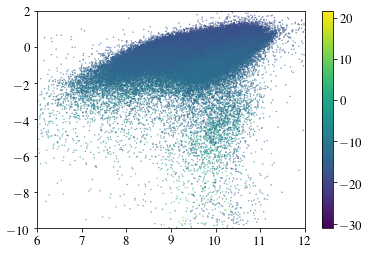

124253


In [8]:
print(len(lm), len(uvs))

plt.scatter(lm,uv,c =fmag, s = 0.1)
plt.colorbar()
plt.xlim(6,12)
plt.ylim(-10,2.0)
plt.show()

index = np.isfinite(uv)
print(len(uv[index]))



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


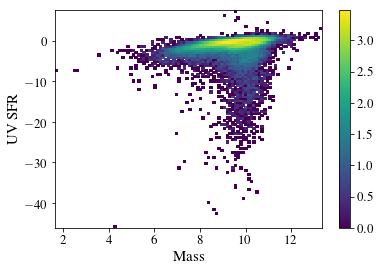

In [9]:
t = binned_statistic_2d(lm[index],uv[index],ind[index], statistic = 'count',bins = (100,100))

yedges = t[1]
xedges = t[2]
xbins = [0.5*(t[1][i] + t[1][i+1]) for i in range(25)]
ybins = [0.5*(t[2][i] + t[2][i+1]) for i in range(25)]
extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]

number = np.ma.array(t[0], mask = t[0] == 0)
number = np.log10(number)

plt.pcolormesh(yedges,xedges,(np.transpose(number)),cmap = plt.cm.viridis)
plt.colorbar()
# plt.xlim(0,0.056)
# plt.ylim(min(gr),max(gr))
# plt.ylim(0,8.0)
# plt.xlim(-3.0,3.0)
plt.xlabel('Mass')
plt.ylabel('UV SFR')
# plt.xlim(8.0,12.0)
# plt.ylim(-6.0,2.0)
#plt.ylim()
plt.show()

In [10]:

stuff = np.column_stack((d['NSAID'],uv))
filename3 = "nsaid_uvsfr"

f3 = open(filename3,'w')
for line in stuff:
    f3.write("  ".join(str(x) for x in line) + "\n")
f3.close()


In [11]:
d.dtype.names

('IAUNAME',
 'SUBDIR',
 'RA',
 'DEC',
 'ISDSS',
 'INED',
 'ISIXDF',
 'IALFALFA',
 'IZCAT',
 'ITWODF',
 'MAG',
 'Z',
 'ZSRC',
 'SIZE',
 'RUN',
 'CAMCOL',
 'FIELD',
 'RERUN',
 'XPOS',
 'YPOS',
 'ZLG',
 'ZDIST',
 'ZDIST_ERR',
 'NSAID',
 'NMGY',
 'NMGY_IVAR',
 'OK',
 'RNMGY',
 'ABSMAG',
 'AMIVAR',
 'EXTINCTION',
 'KCORRECT',
 'KCOEFF',
 'MTOL',
 'B300',
 'B1000',
 'METS',
 'MASS',
 'XCEN',
 'YCEN',
 'NPROF',
 'PROFMEAN',
 'PROFMEAN_IVAR',
 'QSTOKES',
 'USTOKES',
 'BASTOKES',
 'PHISTOKES',
 'PETROFLUX',
 'PETROFLUX_IVAR',
 'FIBERFLUX',
 'FIBERFLUX_IVAR',
 'BA50',
 'PHI50',
 'BA90',
 'PHI90',
 'SERSICFLUX',
 'SERSICFLUX_IVAR',
 'SERSIC_N',
 'SERSIC_BA',
 'SERSIC_PHI',
 'ASYMMETRY',
 'CLUMPY',
 'DFLAGS',
 'AID',
 'PID',
 'DVERSION',
 'PROFTHETA',
 'PETROTHETA',
 'PETROTH50',
 'PETROTH90',
 'SERSIC_TH50',
 'OBJNO',
 'PLATE',
 'FIBERID',
 'MJD',
 'COEFF',
 'VDISP',
 'D4000',
 'D4000ERR',
 'FA',
 'FAERR',
 'S2FLUX',
 'S2FLUXERR',
 'S2EW',
 'S2EWERR',
 'S2VMEAS',
 'S2VMERR',
 'S2RATIO',
 'HAFLUX'

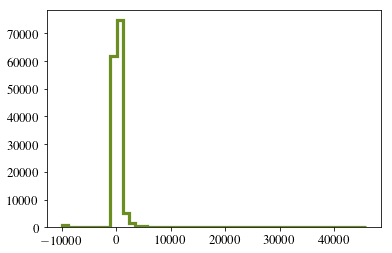

In [13]:
ha = d['HAFLUX']



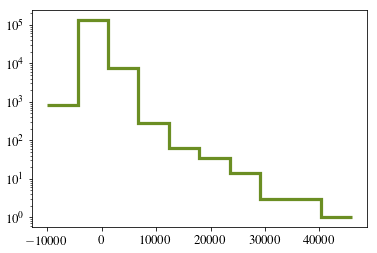

In [15]:
plt.hist(ha, bins=10, histtype = 'step', fill = False, color = 'olivedrab',linewidth=3.2)
plt.yscale('log')
plt.show()

In [18]:
index = np.where(ha==0)[0]
print(len(ha[index]))

index = np.where(ha<=0)[0]
print(len(ha[index]))

index = np.where(ha>0)[0]
print(len(ha[index]))

31660
35508
109647


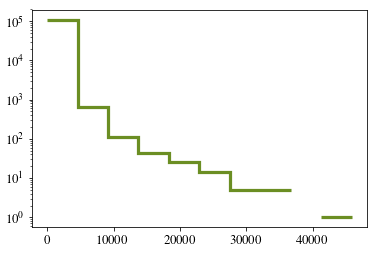

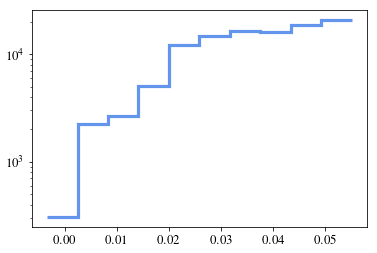

In [21]:
plt.hist(ha[index], bins=10, histtype = 'step', fill = False, color = 'olivedrab',linewidth=3.2)
plt.yscale('log')
plt.show()

plt.hist(z[index], bins=10, histtype = 'step', fill = False, color = 'cornflowerblue',linewidth=3.2)
plt.yscale('log')
plt.show()